In [14]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def load_data(folder='results'):
    data = {}
    test_types = os.listdir(folder)
    for test_type in test_types:
        path = f'{folder}/{test_type}/deals_history.pkl'
        with open(path, 'rb') as f:
            result = processing_data(pickle.load(f))
            data[test_type] = result
    return data


def processing_data(data):
    data = (pd.DataFrame(data)
        .dropna()
        .assign(balance_profit = lambda _df: 100 * (_df.close_balance-_df.entry_balance) / _df.close_balance)
        .assign(profit = lambda _df: 100 * (_df.close_price-_df.entry_price) / _df.close_price)
    )
    return data

In [3]:
data = load_data()
test_types = list(data)
test_types.sort()

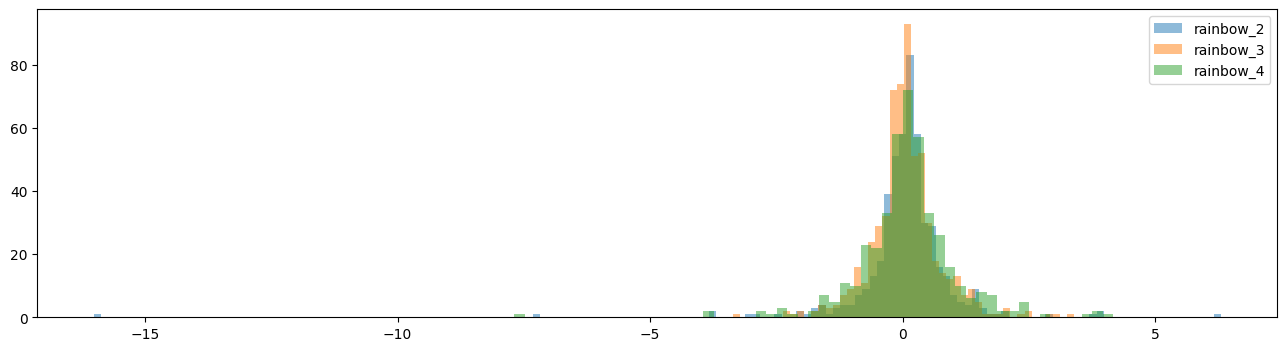

In [5]:
using_results = ['rainbow_2', 'rainbow_3', 'rainbow_4']
plt.figure(figsize=(16,4))
for test_type in test_types:
    if test_type not in using_results:
        continue
    plt.hist(data[test_type].profit, bins='auto', label=test_type, alpha=0.5)
plt.legend()

In [6]:
for test_type in test_types:
    print(f'{test_type} avg profit: {data[test_type].profit.mean():.3f}')

base_dqn avg profit: 0.115
double_dqn avg profit: 0.063
dueling_dqn avg profit: 0.084
rainbow_2 avg profit: 0.056
rainbow_3 avg profit: 0.049
rainbow_4 avg profit: 0.098


In [7]:
for test_type in test_types:
    print(f'{test_type} median profit: {data[test_type].profit.median():.3f}')

base_dqn median profit: 0.084
double_dqn median profit: 0.041
dueling_dqn median profit: 0.120
rainbow_2 median profit: 0.115
rainbow_3 median profit: 0.039
rainbow_4 median profit: 0.093


In [12]:
for test_type in test_types:
    print(f'{test_type} median balance profit: {data[test_type].balance_profit.mean():.3f}')

base_dqn median balance profit: 0.015
double_dqn median balance profit: -0.037
dueling_dqn median balance profit: -0.016
rainbow_2 median balance profit: -0.043
rainbow_3 median balance profit: -0.050
rainbow_4 median balance profit: -0.002


In [9]:
clip_value = 0.5
for test_type in test_types:
    print(f'Clip [-{clip_value}, {clip_value}] {test_type} avg profit: {data[test_type].profit.mean():.3f}')

# print(f'Clip [-{clip_value}, {clip_value}] Base avg profit: {base_results.profit.clip(-clip_value,clip_value).mean():.3f}')
# print(f'Clip [-{clip_value}, {clip_value}] Double avg profit: {double_results.profit.clip(-clip_value,clip_value).mean():.3f}')
# print(f'Clip [-{clip_value}, {clip_value}] Dueling avg profit: {dueling_results.profit.clip(-clip_value,clip_value).mean():.3f}')
# print(f'Clip [-{clip_value}, {clip_value}] Rainbow2 avg profit: {rainbow2_results.profit.clip(-clip_value,clip_value).mean():.3f}')

Clip [-0.5, 0.5] base_dqn avg profit: 0.115
Clip [-0.5, 0.5] double_dqn avg profit: 0.063
Clip [-0.5, 0.5] dueling_dqn avg profit: 0.084
Clip [-0.5, 0.5] rainbow_2 avg profit: 0.056
Clip [-0.5, 0.5] rainbow_3 avg profit: 0.049
Clip [-0.5, 0.5] rainbow_4 avg profit: 0.098


In [10]:
for test_type in test_types:
    print(f'{test_type} std profit: {data[test_type].profit.std():.3f}')

base_dqn std profit: 0.812
double_dqn std profit: 0.775
dueling_dqn std profit: 0.750
rainbow_2 std profit: 1.127
rainbow_3 std profit: 0.690
rainbow_4 std profit: 1.001


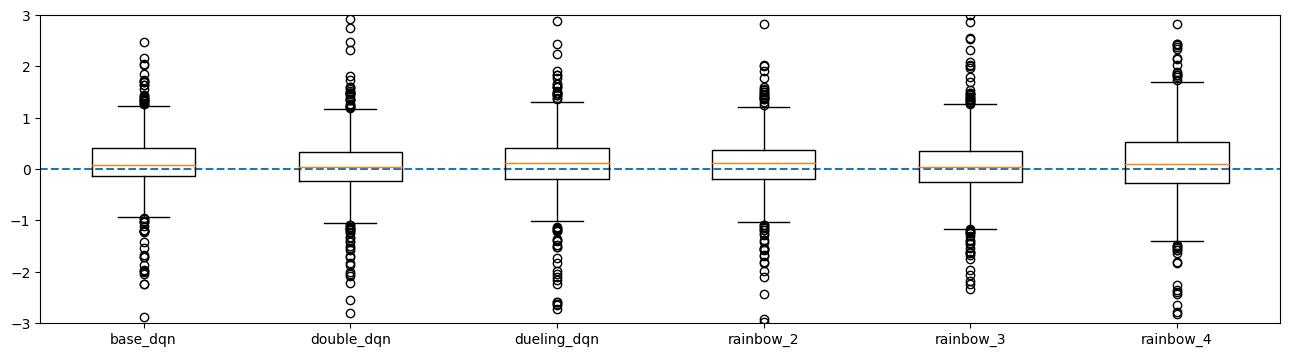

In [11]:
plt.figure(figsize=(16,4))
plt.axhline(0, linestyle='--')
plt.boxplot([data[test_type].profit.values for test_type in test_types], labels=test_types)
plt.ylim(-3,3)
# plt.legend()
print()

In [15]:
for test_type in test_types:
    coef = np.corrcoef(data[test_type].profit, data[test_type].predict_q)
    print(f'{test_type} corr coef with profit and Q value: {coef[0, 1]:.3f}')

base_dqn corr coef with profit and Q value: -0.004
double_dqn corr coef with profit and Q value: 0.023
dueling_dqn corr coef with profit and Q value: 0.042
rainbow_2 corr coef with profit and Q value: 0.092
rainbow_3 corr coef with profit and Q value: 0.040
rainbow_4 corr coef with profit and Q value: -0.015


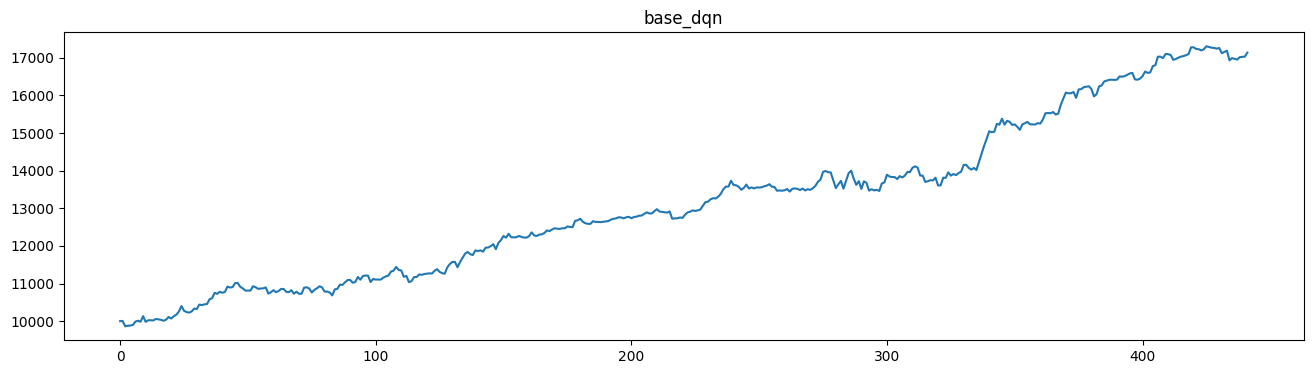

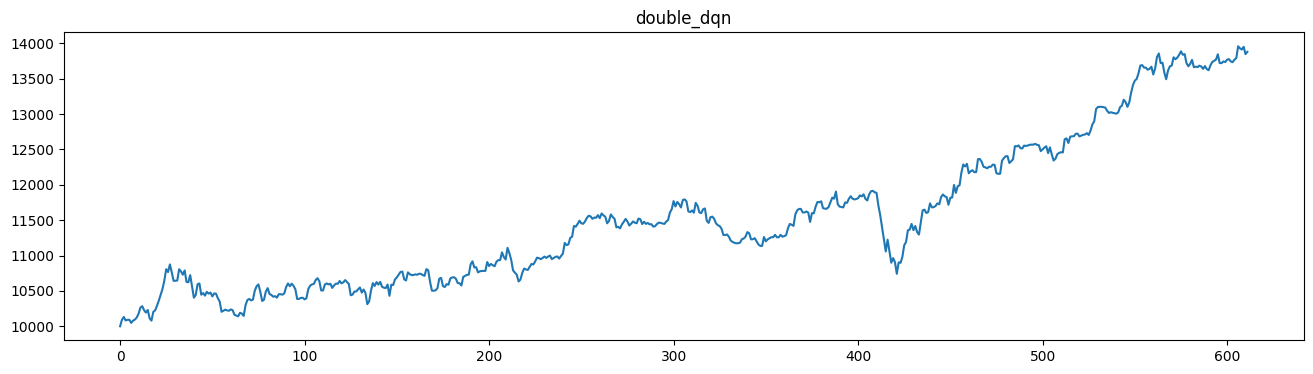

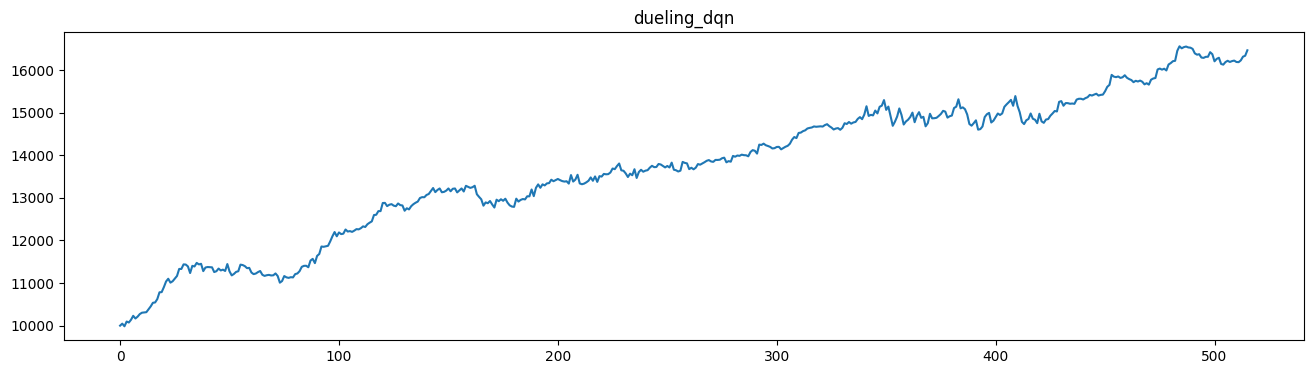

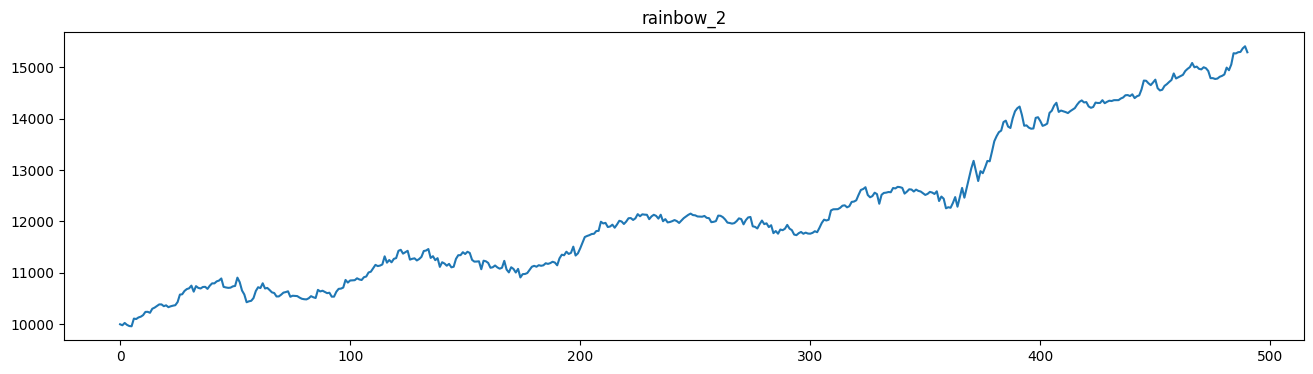

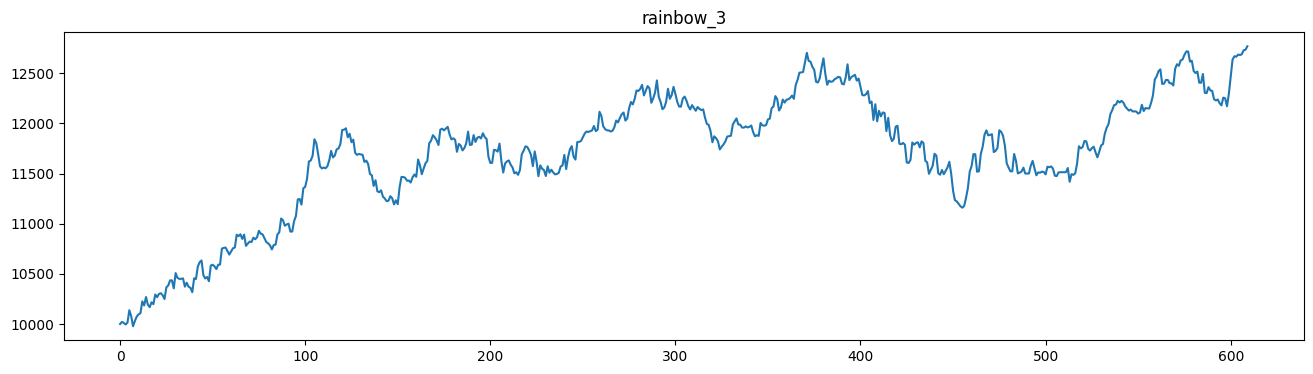

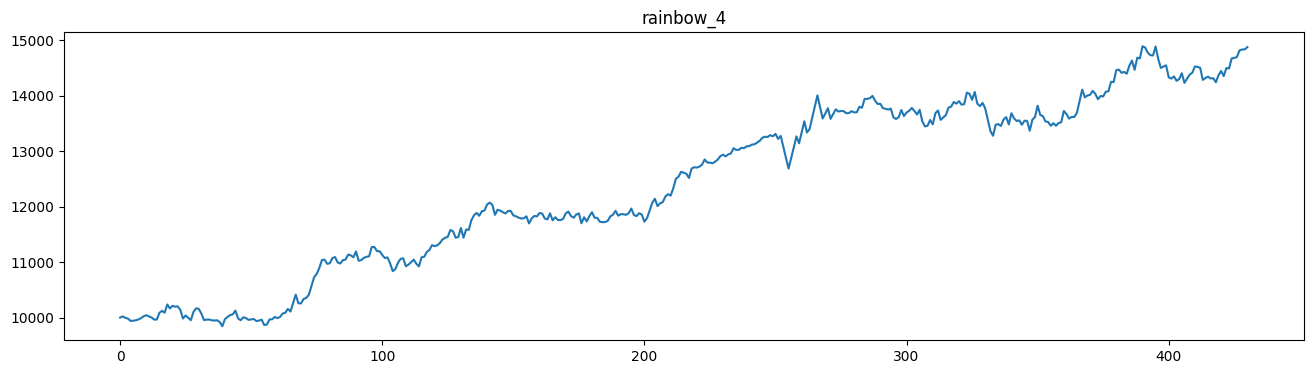

In [16]:
for test_type in test_types:
    profit = 1 + data[test_type].profit.clip(-1.5, 1.5)/100 
    balance = [10_000]
    for it in profit:
        balance.append(balance[-1]*it)
    
    plt.figure(figsize=(16,4))
    plt.title(test_type)
    plt.plot(balance)

In [1]:
import torch

In [21]:
t1 = torch.rand(100,3,50)
idx = torch.randint(0, 3, (100,))

In [36]:
t1.gather(1, idx.unsqueeze(1).expand((100, 50)).unsqueeze(1)).squeeze()

tensor([[0.9670, 0.4176, 0.4901,  ..., 0.3408, 0.7589, 0.3325],
        [0.6261, 0.1588, 0.5869,  ..., 0.6589, 0.1647, 0.3100],
        [0.5647, 0.8498, 0.9589,  ..., 0.3802, 0.8331, 0.2290],
        ...,
        [0.4111, 0.5521, 0.3315,  ..., 0.0965, 0.9667, 0.9592],
        [0.9660, 0.0828, 0.3274,  ..., 0.9786, 0.0964, 0.5037],
        [0.8613, 0.7137, 0.1474,  ..., 0.7256, 0.4172, 0.3764]])

In [37]:
idx

tensor([2, 1, 0, 1, 2, 1, 1, 2, 1, 0, 0, 0, 0, 2, 2, 0, 1, 0, 1, 0, 2, 2, 0, 0,
        1, 1, 1, 1, 2, 0, 0, 1, 0, 0, 2, 2, 2, 0, 0, 1, 0, 0, 1, 2, 1, 2, 0, 1,
        2, 1, 2, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 2, 0, 0, 2, 1, 0, 2, 2, 0, 1, 1,
        1, 2, 0, 2, 1, 1, 2, 2, 2, 0, 0, 2, 1, 0, 0, 1, 2, 0, 2, 1, 1, 1, 1, 2,
        2, 2, 1, 2])

In [40]:
t1[1, 1]

tensor([0.6261, 0.1588, 0.5869, 0.5097, 0.2927, 0.5609, 0.0702, 0.7159, 0.3890,
        0.7025, 0.6199, 0.6772, 0.7153, 0.4154, 0.1971, 0.6247, 0.7626, 0.9511,
        0.6164, 0.9830, 0.6410, 0.7374, 0.0889, 0.1915, 0.8755, 0.6142, 0.8119,
        0.3777, 0.7745, 0.0677, 0.2144, 0.2118, 0.0699, 0.7869, 0.6635, 0.2122,
        0.3426, 0.0936, 0.4287, 0.6130, 0.2397, 0.5412, 0.4990, 0.1356, 0.8152,
        0.2902, 0.2220, 0.6589, 0.1647, 0.3100])